# Задание

In [31]:
import requests
import tarfile
import os

public_link = "https://disk.yandex.ru/d/kwFFpqcZl8DnUg"
file_path = "/kth_tips_grey_200x200.tar"

download_api = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
params = {"public_key": public_link, "path": file_path}

href = requests.get(download_api, params=params).json()["href"]

local_name = file_path.split("/")[-1] 
r = requests.get(href)

with open(local_name, "wb") as f:
    f.write(r.content)

print("Скачан файл:", local_name)

# Распаковка архива
extract_path = "."
with tarfile.open(local_name, 'r') as tar:
    tar.extractall(extract_path)

# Определение пути к папке с текстурами
image_folder = None
for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if os.path.isdir(item_path) and "KTH" in item.upper():
        image_folder = item_path
        break

if image_folder is None:
    # Если папка не найдена, создаем путь по умолчанию
    image_folder = os.path.join(extract_path, "KTH_TIPS")
    if not os.path.exists(image_folder):
        image_folder = extract_path

print(f"Архив распакован. Путь к текстурам: {image_folder}")


texture_path = None
image_path = None

if os.path.exists(image_folder):
    texture_names = [name for name in os.listdir(image_folder) 
                     if os.path.isdir(os.path.join(image_folder, name))]
    
    if texture_names:
        texture_name = texture_names[0]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        if image_files:
            image_path = os.path.join(texture_path, image_files[0])
            print(f"texture_path: {texture_path}")
            print(f"image_path: {image_path}")
        else:
            print("В папке текстуры не найдено изображений")
    else:
        print("В папке не найдено подпапок с текстурами")


Скачан файл: kth_tips_grey_200x200.tar
Архив распакован. Путь к текстурам: ./KTH_TIPS
texture_path: ./KTH_TIPS/linen
image_path: ./KTH_TIPS/linen/44-scale_7_im_7_grey.png


/tmp/ipython-input-1900385742.py:24: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_path)


# 1. Текстурные характеристики:

## 1.1. Реализуйте подсчет гистограммы 

In [32]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import entropy, skew, kurtosis

In [33]:
def compute_histogram(image, bins):
    hist = cv.calcHist([image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    
    bin_width = 256 / bins
    bin_centers = np.array([i * bin_width + bin_width / 2 for i in range(bins)])
    hist_normalized = hist / np.sum(hist)
    
    weighted_data = np.repeat(bin_centers, hist.astype(int))
    
    features = {
        'mean': np.average(bin_centers, weights=hist),
        'variance': np.var(weighted_data) if len(weighted_data) > 0 else 0,
        'std_dev': np.std(weighted_data) if len(weighted_data) > 0 else 0,
        'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
        'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
        'energy': np.sum(hist_normalized**2),
        'entropy': entropy(hist_normalized),
        'median': np.median(image),
        'percentile_25': np.percentile(image, 25),
        'percentile_75': np.percentile(image, 75),
        'min': np.min(image),
        'max': np.max(image),
        'contrast': np.max(image) - np.min(image)
    }
    
    return features, hist_normalized

In [34]:
# Data for function showcase
image_folder = "./KTH_TIPS"

texture_name = os.listdir(image_folder)[0]
texture_path = os.path.join(image_folder, texture_name)

image_files = [f for f in os.listdir(texture_path)]
image_path = os.path.join(texture_path, image_files[10])
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

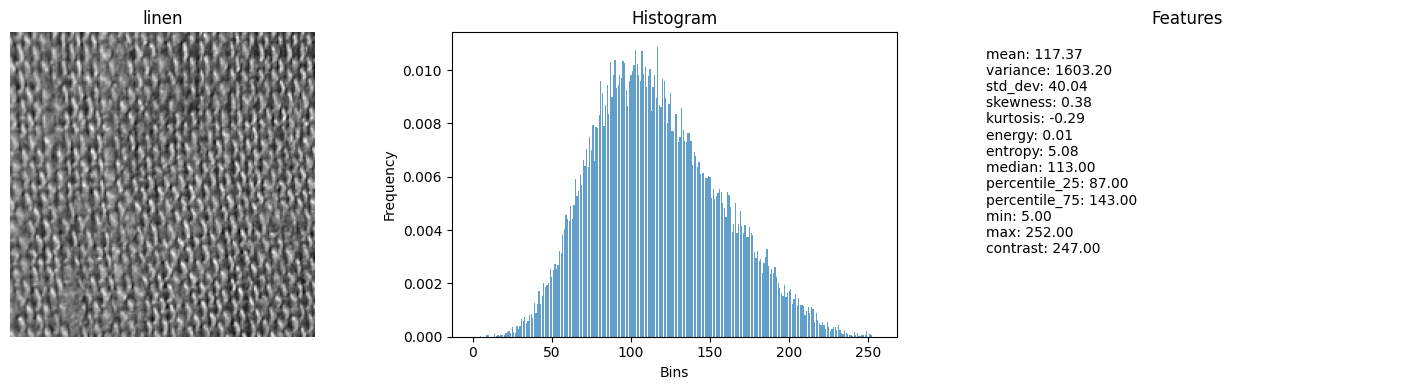

In [35]:
bins_count = 256
features, hist = compute_histogram(image, bins=bins_count)

# Visualization
fig, (ax_img, ax_hist, ax_stats) = plt.subplots(1, 3, figsize=(15, 4))

# Image
ax_img.imshow(image, cmap='gray')
ax_img.set_title(texture_name)
ax_img.axis('off')

# Histogram
ax_hist.bar(range(bins_count), hist, alpha=0.7)
ax_hist.set_title('Histogram')
ax_hist.set_xlabel('Bins')
ax_hist.set_ylabel('Frequency')

# Statistics
stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in features.items()])
ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, verticalalignment='top')
ax_stats.set_title('Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

## 1.2. Реализуйте рассчет текстурных характеристик Laws 

In [36]:
def laws_texture(image):
    kernels = [
        ([1,4,6,4,1], 'L5'),     # Level
        ([-1,-2,0,2,1], 'E5'),   # Edge  
        ([-1,0,2,0,-1], 'S5'),   # Spot
        ([-1,2,0,-2,1], 'W5'),   # Wave
        ([1,-4,6,-4,1], 'R5')    # Ripple
    ]
    
    features_dict = {}
    
    # Generate 2D kernels and compute energy
    for k1, name1 in kernels:
        for k2, name2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = cv.filter2D(image.astype(np.float32), -1, kernel)
            features_dict[f"{name1}{name2}"] = np.mean(filtered ** 2)
    
    # Normalize
    total = sum(features_dict.values())
    if total > 0:
        for key in features_dict:
            features_dict[key] /= total
    
    return features_dict

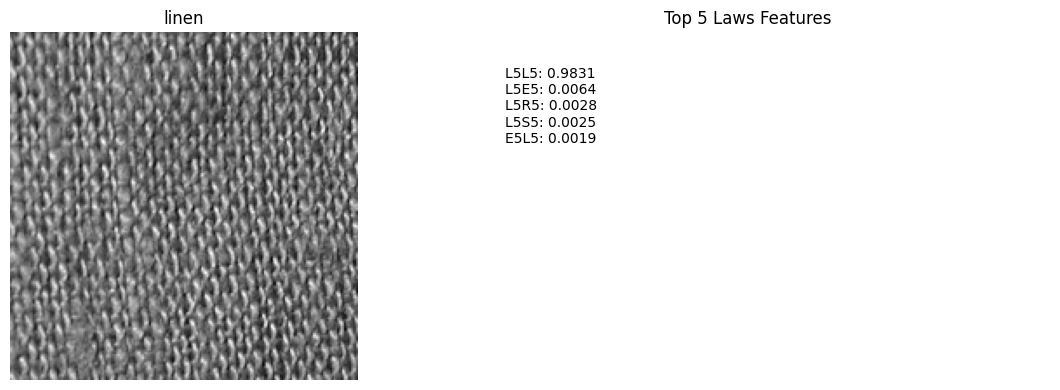

In [37]:
features_dict = laws_texture(image)

# Visualization
fig, (ax_img, ax_stats) = plt.subplots(1, 2, figsize=(12, 4))

# Image
ax_img.imshow(image, cmap='gray')
ax_img.set_title(texture_name)
ax_img.axis('off')

# Top-5 Laws features
top_5 = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:5]
stats_text = '\n'.join([f'{k}: {v:.4f}' for k, v in top_5])

ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes, verticalalignment='top')
ax_stats.set_title('Top 5 Laws Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

## 1.3. Реализуйте расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM

In [38]:
from skimage.feature import graycomatrix, graycoprops

In [ ]:
def compute_glcm_features(image):
    distances = [1]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

    image_quantized = (image // 8).astype(np.uint8)
    glcm = graycomatrix(
        image_quantized, 
        distances=distances, 
        angles=angles, 
        levels=32, 
        symmetric=True, 
        normed=True
    )
    
    # Calculate texture properties
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = {}
    
    for prop in properties:
        feature_val = np.mean(graycoprops(glcm, prop))
        # Replace NaN and Inf with 0
        if np.isnan(feature_val) or np.isinf(feature_val):
            feature_val = 0.0
        features[prop] = feature_val
    
    return features

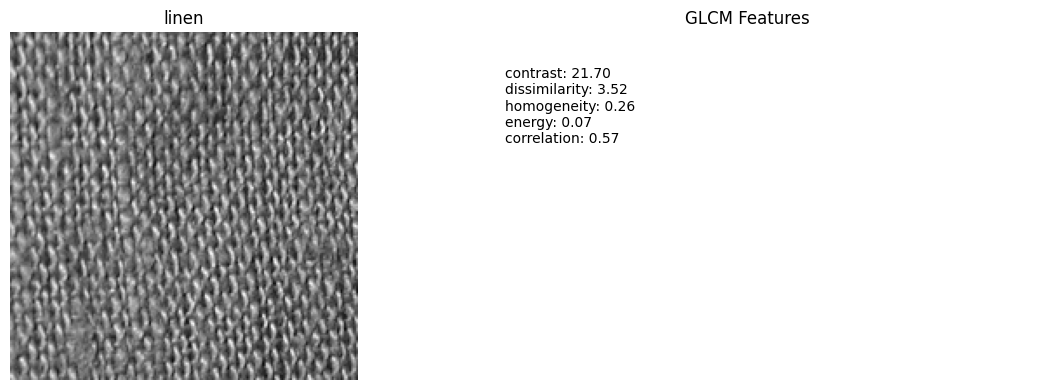

In [40]:
features = compute_glcm_features(image)

# Visualization
fig, (ax_img, ax_stats) = plt.subplots(1, 2, figsize=(12, 4))

# Image
ax_img.imshow(image, cmap='gray')
ax_img.set_title(texture_name)
ax_img.axis('off')

# GLCM features
stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in features.items()])

ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes, verticalalignment='top')
ax_stats.set_title('GLCM Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

# 2. Для каждого случая: выполните тренировку классификатора (knn, svm, trees)

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import classification_report, accuracy_score
import warnings

In [42]:
def prepare_dataset(image_folder, feature_type, num_images=50):
    features, labels = [], []
    
    for texture_name in os.listdir(image_folder):
        texture_path = os.path.join(image_folder, texture_name)
        if not os.path.isdir(texture_path):
            continue
        
        for image_file in os.listdir(texture_path)[:num_images]:
            image_path = os.path.join(texture_path, image_file)
            image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            
            if image is not None:
                image = cv.resize(image, (128, 128))
                
                if feature_type == 'Histogram':
                    features_dict, _ = compute_histogram(image, 256)
                elif feature_type == 'Laws':
                    features_dict = laws_texture(image)
                else:  # GLCM
                    features_dict = compute_glcm_features(image)
                
                features.append(list(features_dict.values()))
                labels.append(texture_name)
    
    return np.array(features), labels


def train_models(X, y):
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    classifiers = {
        'KNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
    }
    
    models = {name: clf.fit(X_train_scaled, y_train) for name, clf in classifiers.items()}

    return models, X_test_scaled, y_test, scaler

In [43]:
# Train models for each feature type
trained_models_dict = {}

feature_types = ['Histogram', 'Laws', 'GLCM']
for feature_type in feature_types:
    print(f"Training {feature_type} models...")
    
    X, labels = prepare_dataset(image_folder, feature_type, 50)
    models, X_test, y_test, scaler = train_models(X, labels)
    
    trained_models_dict[feature_type] = {
        'models': models, 'scaler': scaler
    }
    
    print(f"  Data: {X.shape}")
    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            f1 = report['macro avg']['f1-score']
        
        print(f"  {name}: Acc={accuracy:.3f}, F1={f1:.3f}")
    print()

Training Histogram models...
  Data: (500, 13)
  KNN: Acc=0.816, F1=0.816
  SVM: Acc=0.784, F1=0.787
  DecisionTree: Acc=0.816, F1=0.814

Training Laws models...
  Data: (500, 25)
  KNN: Acc=0.760, F1=0.758
  SVM: Acc=0.480, F1=0.479
  DecisionTree: Acc=0.624, F1=0.621

Training GLCM models...
  Data: (500, 5)
  KNN: Acc=0.496, F1=0.485
  SVM: Acc=0.512, F1=0.503
  DecisionTree: Acc=0.448, F1=0.467



# 3. Решите задачу сегментации данных на основе классификации изображений каждым методом.

In [65]:
IMAGE_URL = "https://thumbs.dreamstime.com/b/%D1%87%D0%B5%D1%80%D0%BD%D1%8B%D0%B9-%D1%85%D0%BB%D0%B5%D0%B1-%D1%83%D0%B3%D0%BB%D1%8F-17359541.jpg"

image_path = "./test_image.png"

if IMAGE_URL:
    try:
        print(f"Загрузка изображения по URL: {IMAGE_URL}")
        response = requests.get(IMAGE_URL, timeout=30)
        response.raise_for_status()
        
        # Определяем расширение файла из URL или используем jpg по умолчанию
        if '.jpg' in IMAGE_URL.lower() or '.jpeg' in IMAGE_URL.lower():
            image_path = "./test_image.jpg"
        elif '.png' in IMAGE_URL.lower():
            image_path = "./test_image.png"
        else:
            image_path = "./test_image.jpg"
        
        # Сохраняем изображение
        with open(image_path, 'wb') as f:
            f.write(response.content)
        
        # Загружаем и конвертируем в grayscale если нужно
        img = cv.imread(image_path)
        if img is not None:
            # Если изображение цветное, конвертируем в grayscale
            if len(img.shape) == 3:
                img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                cv.imwrite(image_path, img_gray)
            print(f"✓ Изображение успешно загружено и сохранено: {image_path}")
            print(f"  Размер изображения: {img.shape[1]}x{img.shape[0]} пикселей")
        else:
            print("✗ Ошибка: не удалось загрузить изображение из URL")
            image_path = None
    except Exception as e:
        print(f"✗ Ошибка при загрузке изображения по URL: {e}")
        print("  Будет использован локальный файл или создано составное изображение")
        image_path = None
else:
    print("URL не указан, будет использован локальный файл или создано составное изображение")
    image_path = "./test_image.png"

# Сохраняем путь для использования в следующих ячейках
if image_path:
    TEST_IMAGE_PATH = image_path
    print(f"\nПуть к изображению для использования: {TEST_IMAGE_PATH}")
else:
    TEST_IMAGE_PATH = "./test_image.png"

Загрузка изображения по URL: https://thumbs.dreamstime.com/b/%D1%87%D0%B5%D1%80%D0%BD%D1%8B%D0%B9-%D1%85%D0%BB%D0%B5%D0%B1-%D1%83%D0%B3%D0%BB%D1%8F-17359541.jpg
✓ Изображение успешно загружено и сохранено: ./test_image.jpg
  Размер изображения: 800x726 пикселей

Путь к изображению для использования: ./test_image.jpg


In [71]:
def texture_segmentation(image, trained_models_dict, feature_type, model_name, window_size=32, step=None, n_classes=4):
    original_image = cv.imread(image, cv.IMREAD_GRAYSCALE)
    
    if original_image is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение: {image}")
    
    if step is None:
        step = window_size
    
    # Get model components
    models = trained_models_dict[feature_type]['models']
    scaler = trained_models_dict[feature_type]['scaler']
    model = models[model_name]
    
    h, w = original_image.shape
    temp_seg_map = np.zeros((h, w), dtype=np.uint8)
    all_predictions = []
    
    feature_extractors = {
        'Histogram': lambda img: list(compute_histogram(img, 32)[0].values()),
        'Laws': lambda img: list(laws_texture(img).values()),
        'GLCM': lambda img: list(compute_glcm_features(img).values())
    }
    
    # Collect all predictions
    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            window = original_image[y:y+window_size, x:x+window_size]
            
            features = feature_extractors[feature_type](window)
            # Convert to numpy array and handle NaN values
            features = np.array(features)
            # Replace NaN and Inf with 0
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
            
            features_scaled = scaler.transform([features])
            prediction = model.predict(features_scaled)[0]
            
            temp_seg_map[y:y+window_size, x:x+window_size] = prediction
            all_predictions.append(prediction)
    
    # Find top n_classes
    unique, counts = np.unique(all_predictions, return_counts=True)
    top_classes = unique[np.argsort(counts)[-n_classes:]]
    
    segmentation_map = np.zeros_like(temp_seg_map)
    
    for new_class, old_class in enumerate(top_classes):
        segmentation_map[temp_seg_map == old_class] = new_class
    
    # Handle pixels not in top classes (assign to most frequent class)
    mask_not_top = ~np.isin(temp_seg_map, top_classes)
    if np.any(mask_not_top):
        segmentation_map[mask_not_top] = 1  # Assign to class 1
    
    return segmentation_map, original_image

In [72]:
def show_segment(image, trained_models_dict, **kwargs):
    seg_map, original = texture_segmentation(image, trained_models_dict, **kwargs)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(seg_map, cmap='tab10')
    ax2.set_title('Segmentation')
    ax2.axis('off')
    
    ax3.imshow(seg_map, cmap='tab10', alpha=0.8)
    ax3.imshow(original, cmap='gray', alpha=0.3)
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

Используется загруженное изображение: ./test_image.jpg
Изображение уменьшено до 272x300 для ускорения обработки

Сегментация для всех комбинаций методов (оптимизированная версия):

Примечание: для ускорения используются увеличенные размеры окон и шаги

Histogram + KNN


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

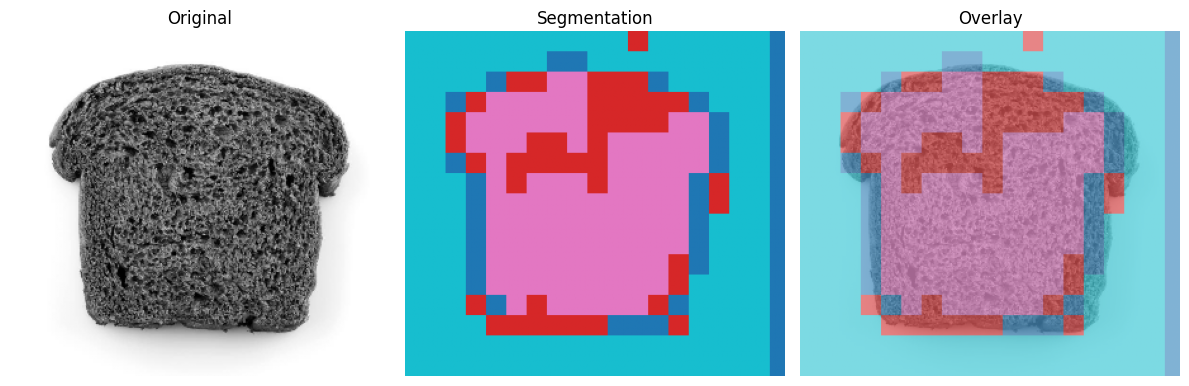

Laws + SVM


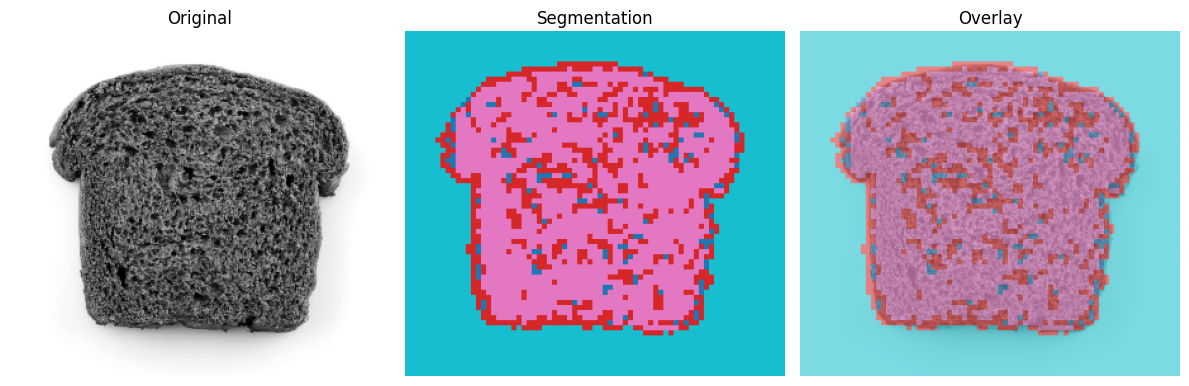

GLCM + DecisionTree


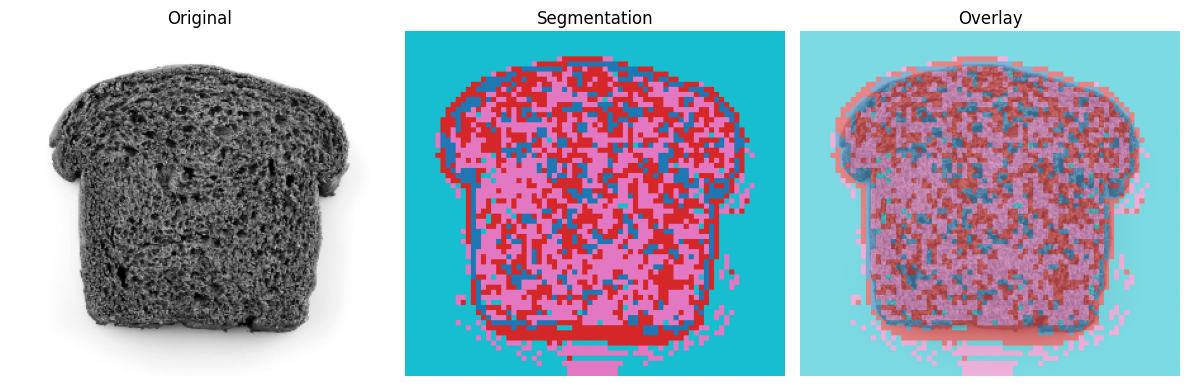

In [73]:
# Используем уже загруженное изображение
if 'TEST_IMAGE_PATH' in globals():
    image_path = TEST_IMAGE_PATH
    print(f"Используется загруженное изображение: {image_path}")
else:
    raise FileNotFoundError(
        "Изображение не загружено! Сначала выполните ячейку 21 для загрузки изображения."
    )

# Проверяем существование файла
if not os.path.exists(image_path):
    raise FileNotFoundError(
        f"Файл изображения не найден: {image_path}\n"
        "Убедитесь, что ячейка 21 была успешно выполнена."
    )

test_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
if test_img is not None and test_img.shape[0] > 300:
    scale = 300 / max(test_img.shape)
    new_size = (int(test_img.shape[1] * scale), int(test_img.shape[0] * scale))
    test_img_resized = cv.resize(test_img, new_size)
    image_path_resized = "./test_image_resized.png"
    cv.imwrite(image_path_resized, test_img_resized)
    image_path = image_path_resized
    print(f"Изображение уменьшено до {new_size[1]}x{new_size[0]} для ускорения обработки")

feature_types = ['Histogram', 'Laws', 'GLCM']
model_names = ['KNN', 'SVM', 'DecisionTree']
window_sizes = {'Histogram': 32, 'Laws': 8, 'GLCM': 8} 
steps = {'Histogram': 16, 'Laws': 4, 'GLCM': 4} 

print("\nСегментация для всех комбинаций методов (оптимизированная версия):\n")
print("Примечание: для ускорения используются увеличенные размеры окон и шаги\n")

examples_to_show = [
    ('Histogram', 'KNN'),
    ('Laws', 'SVM'),
    ('GLCM', 'DecisionTree')
]

for feature_type, model_name in examples_to_show:
    print(f"{feature_type} + {model_name}")
    show_segment(image_path, trained_models_dict, 
                window_size=window_sizes[feature_type],
                step=steps[feature_type],
                feature_type=feature_type, 
                model_name=model_name)


# 4. Выполните ручную разметку изображений на регионы.

In [74]:
def manual_segment(image):
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    _, mask = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(mask)

    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        cv.drawContours(final_mask, [largest_contour], 0, 1, -1)
    
    return final_mask


def remap_classes(mask, n_classes):
    unique, counts = np.unique(mask, return_counts=True)
    top_classes = unique[np.argsort(-counts)[:n_classes]]

    result = np.zeros_like(mask)
    for new_id, old_id in enumerate(top_classes):
        result[mask == old_id] = new_id

    return result

In [ ]:
if 'TEST_IMAGE_PATH' in globals():
    image_path = TEST_IMAGE_PATH
    print(f"Используется изображение из предыдущей ячейки: {image_path}")
else:
    raise FileNotFoundError(
        "Изображение не загружено! Сначала выполните ячейку 25 для загрузки изображения по URL."
    )

# Проверяем существование файла
if not os.path.exists(image_path):
    raise FileNotFoundError(
        f"Файл изображения не найден: {image_path}\n"
        "Убедитесь, что ячейка 25 была успешно выполнена."
    )

file_ext = os.path.splitext(image_path)[1] or '.png'
image_path_resized = f"./test_image_resized{file_ext}"
if os.path.exists(image_path_resized):
    image_path = image_path_resized
    print(f"Используется уменьшенное изображение: {image_path}")

image = cv.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

manual_mask = manual_segment(image_rgb)
manual_mask = remap_classes(manual_mask, 4)

Используется изображение из предыдущей ячейки: ./test_image.jpg


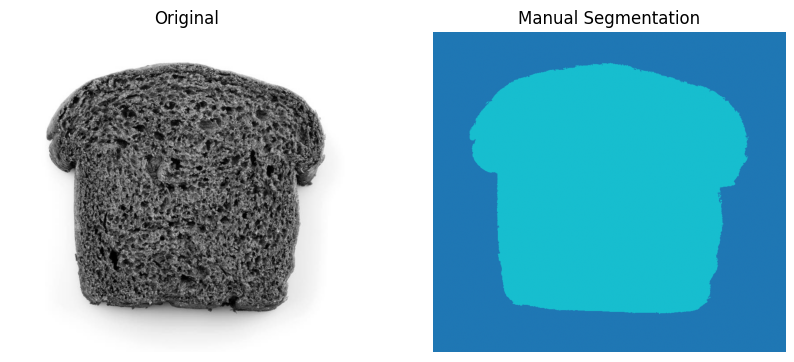

In [ ]:
fig, (ax_orig, ax_segment) = plt.subplots(1, 2, figsize=(10, 5))

ax_orig.imshow(image_rgb)
ax_orig.set_title('Original')
ax_orig.axis('off')

ax_segment.imshow(manual_mask, cmap='tab10')
ax_segment.set_title('Manual Segmentation')
ax_segment.axis('off')

plt.show()

# 4.2. Сравните результат полученной классификации и размеченной.

In [77]:
from sklearn.metrics import accuracy_score, jaccard_score

In [78]:
def find_best_mapping(true_mask, pred_mask):
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()
    
    true_classes = np.unique(true_flat)
    pred_classes = np.unique(pred_flat)
    
    mapping = {}
    for pred_class in pred_classes:
        best_true_class = None
        best_overlap = -1
        
        for true_class in true_classes:
            overlap = np.sum((true_flat == true_class) & (pred_flat == pred_class))
            if overlap > best_overlap:
                best_overlap = overlap
                best_true_class = true_class
        
        mapping[pred_class] = best_true_class
    
    return mapping


def compare_segmentation(manual_mask, predicted_mask, original_img):
    if manual_mask.shape != predicted_mask.shape:
        predicted_mask = cv.resize(predicted_mask, (manual_mask.shape[1], manual_mask.shape[0]))
    
    mapping = find_best_mapping(manual_mask, predicted_mask)
    pred_mapped = np.zeros_like(predicted_mask)
    
    for pred_class, true_class in mapping.items():
        pred_mapped[predicted_mask == pred_class] = true_class
    
    accuracy = accuracy_score(manual_mask.flatten(), pred_mapped.flatten())
    iou_scores = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(), 
                              average=None, labels=np.unique(manual_mask))
    
    print(f"Accuracy: {accuracy:.1%}")
    
    print("IoU per class:")
    for i, class_id in enumerate(np.unique(manual_mask)):
        print(f"  Class {class_id}: {iou_scores[i]:.3f}")
    
    fig, (ax_orig, ax_manual, ax_pred) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax_orig.imshow(original_img, cmap='gray')
    ax_orig.set_title('Original')
    ax_orig.axis('off')
    
    ax_manual.imshow(manual_mask, cmap='tab10')
    ax_manual.set_title('Manual Mask')
    ax_manual.axis('off')
    
    ax_pred.imshow(pred_mapped, cmap='tab10')
    ax_pred.set_title('Predicted Mask')
    ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()

In [79]:
image_path = "./test_image.png"

image_path_resized = "./test_image_resized.png"
if os.path.exists(image_path_resized):
    image_path = image_path_resized
    print(f"Используется уменьшенное изображение: {image_path}")

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Файл {image_path} не найден. Сначала выполните ячейку 23 или 26 для создания тестового изображения.")

image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

feature_types = ['Histogram', 'Laws', 'GLCM']
model_names = ['KNN', 'SVM', 'DecisionTree']
window_sizes = {'Histogram': 32, 'Laws': 8, 'GLCM': 8}
steps = {'Histogram': 16, 'Laws': 4, 'GLCM': 4}

results_summary = []

print("=" * 60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ И РУЧНОЙ РАЗМЕТКИ")
print("=" * 60)
print("Примечание: используются оптимизированные параметры для ускорения")
print("=" * 60)

for feature_type in feature_types:
    for model_name in model_names:
        print(f"\n{feature_type} - {model_name}")
        print("-" * 40)
        
        predicted_mask, _ = texture_segmentation(
            image_path, 
            trained_models_dict,
            window_size=window_sizes[feature_type],
            step=steps[feature_type],
            feature_type=feature_type, 
            model_name=model_name
        )
        
        if manual_mask.shape != predicted_mask.shape:
            predicted_mask = cv.resize(predicted_mask, (manual_mask.shape[1], manual_mask.shape[0]))
        
        mapping = find_best_mapping(manual_mask, predicted_mask)
        pred_mapped = np.zeros_like(predicted_mask)
        
        for pred_class, true_class in mapping.items():
            pred_mapped[predicted_mask == pred_class] = true_class
        
        accuracy = accuracy_score(manual_mask.flatten(), pred_mapped.flatten())
        iou_scores = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(), 
                                  average=None, labels=np.unique(manual_mask))
        mean_iou = np.mean(iou_scores)
        
        results_summary.append({
            'feature_type': feature_type,
            'model': model_name,
            'accuracy': accuracy,
            'mean_iou': mean_iou
        })
        
        print(f"Accuracy: {accuracy:.1%}")
        print(f"Mean IoU: {mean_iou:.3f}")
        print("IoU per class:")
        for i, class_id in enumerate(np.unique(manual_mask)):
            print(f"  Class {class_id}: {iou_scores[i]:.3f}")

print("\n" + "=" * 60)
print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 60)
print(f"{'Feature Type':<15} {'Model':<15} {'Accuracy':<12} {'Mean IoU':<12}")
print("-" * 60)
for result in results_summary:
    print(f"{result['feature_type']:<15} {result['model']:<15} {result['accuracy']:<12.1%} {result['mean_iou']:<12.3f}")

Используется уменьшенное изображение: ./test_image_resized.png
СРАВНЕНИЕ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ И РУЧНОЙ РАЗМЕТКИ
Примечание: используются оптимизированные параметры для ускорения

Histogram - KNN
----------------------------------------


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

Accuracy: 90.1%
Mean IoU: 0.820
IoU per class:
  Class 0: 0.814
  Class 1: 0.826

Histogram - SVM
----------------------------------------


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

Accuracy: 51.5%
Mean IoU: 0.260
IoU per class:
  Class 0: 0.514
  Class 1: 0.006

Histogram - DecisionTree
----------------------------------------


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

Accuracy: 87.5%
Mean IoU: 0.774
IoU per class:
  Class 0: 0.804
  Class 1: 0.745

Laws - KNN
----------------------------------------
Accuracy: 94.7%
Mean IoU: 0.900
IoU per class:
  Class 0: 0.898
  Class 1: 0.902

Laws - SVM
----------------------------------------
Accuracy: 97.2%
Mean IoU: 0.945
IoU per class:
  Class 0: 0.946
  Class 1: 0.945

Laws - DecisionTree
----------------------------------------
Accuracy: 94.6%
Mean IoU: 0.897
IoU per class:
  Class 0: 0.895
  Class 1: 0.900

GLCM - KNN
----------------------------------------
Accuracy: 90.1%
Mean IoU: 0.820
IoU per class:
  Class 0: 0.826
  Class 1: 0.814

GLCM - SVM
----------------------------------------
Accuracy: 95.3%
Mean IoU: 0.910
IoU per class:
  Class 0: 0.909
  Class 1: 0.910

GLCM - DecisionTree
----------------------------------------
Accuracy: 90.1%
Mean IoU: 0.819
IoU per class:
  Class 0: 0.809
  Class 1: 0.829

ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Feature Type    Model           Accuracy     Mean IoU    
---------

Используется уменьшенное изображение: ./test_image_resized.png
Создание визуального сравнения (это может занять некоторое время)...
Обработка: Histogram - KNN


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

Обработка: Histogram - SVM


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

Обработка: Histogram - DecisionTree


/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
/tmp/ipython-input-4142438645.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearl

Обработка: Laws - KNN
Обработка: Laws - SVM
Обработка: Laws - DecisionTree
Обработка: GLCM - KNN
Обработка: GLCM - SVM
Обработка: GLCM - DecisionTree


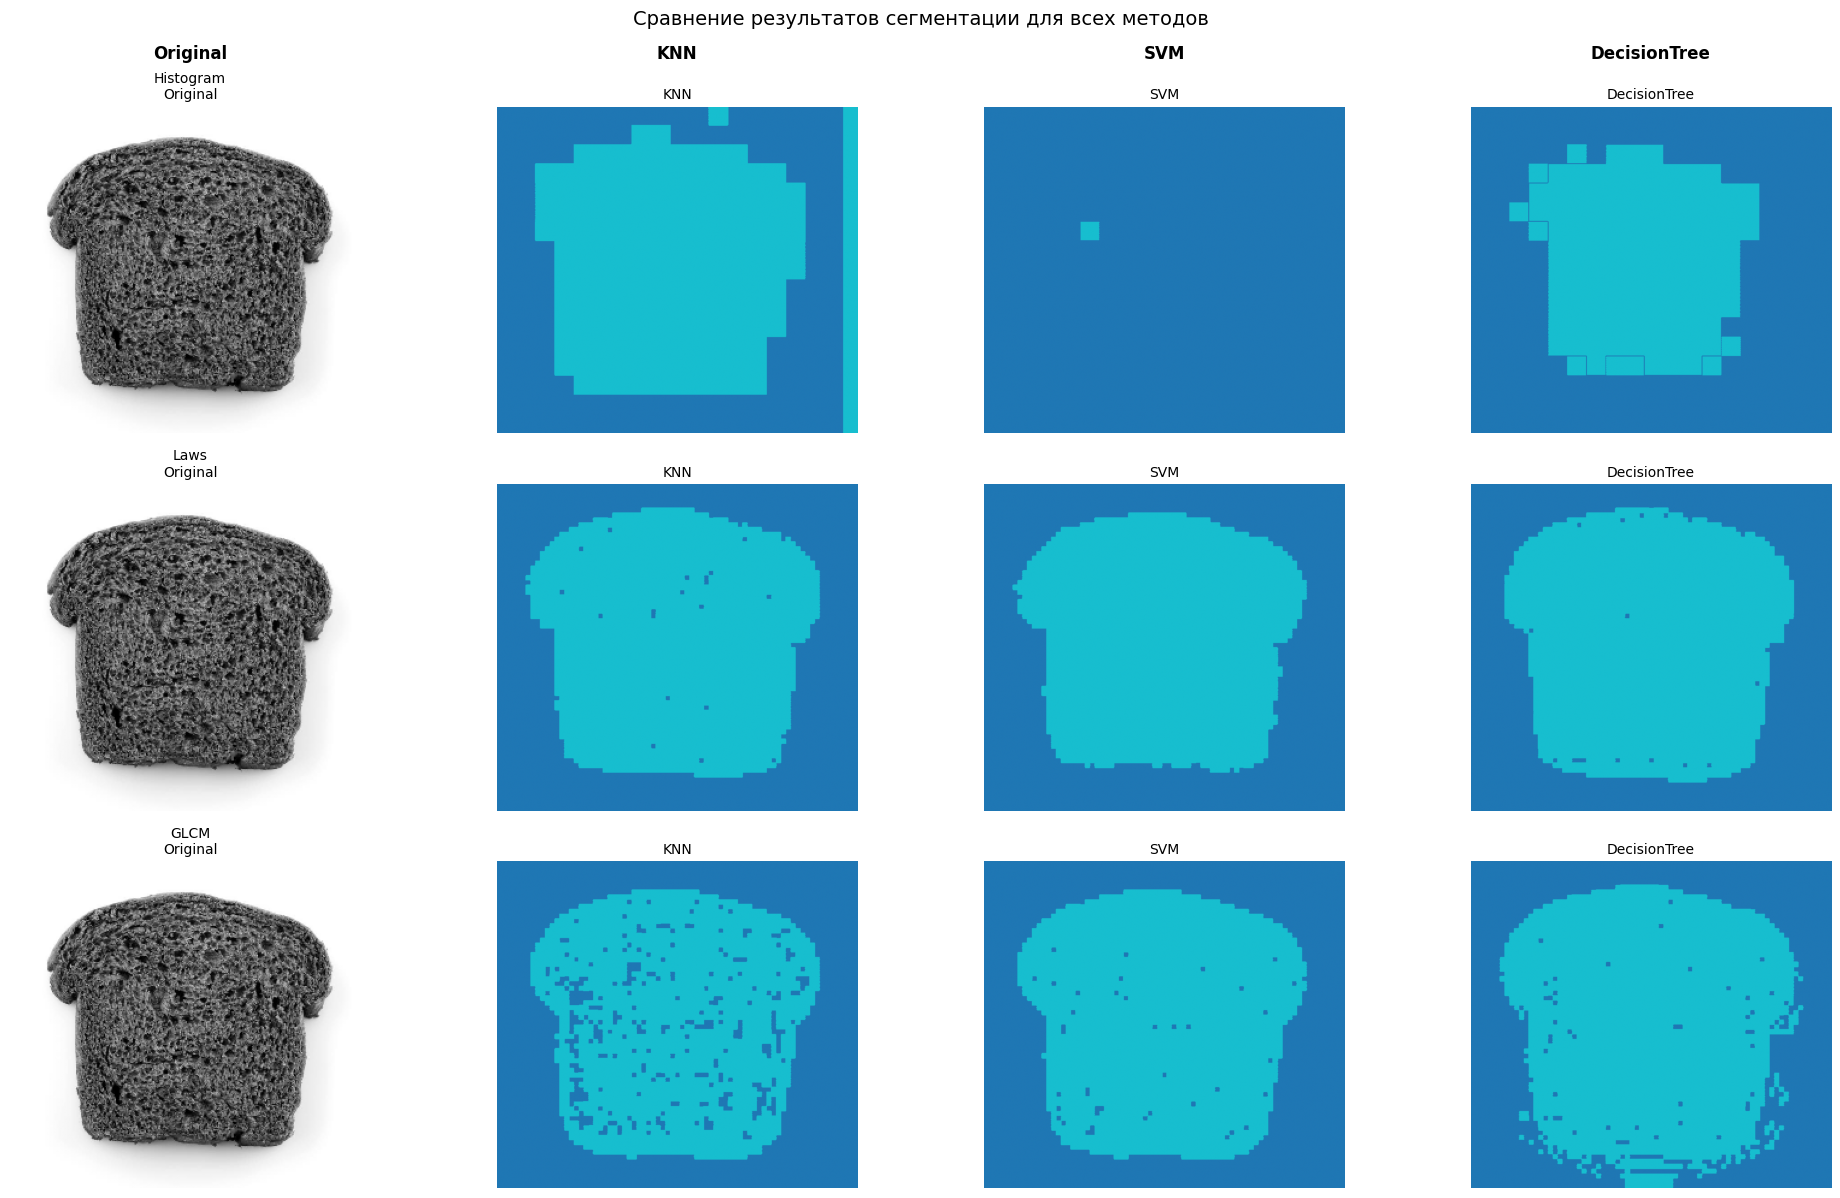

In [80]:
image_path = "./test_image.png"

image_path_resized = "./test_image_resized.png"
if os.path.exists(image_path_resized):
    image_path = image_path_resized
    print(f"Используется уменьшенное изображение: {image_path}")

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Файл {image_path} не найден. Сначала выполните ячейку 23 или 26 для создания тестового изображения.")

image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

feature_types = ['Histogram', 'Laws', 'GLCM']
model_names = ['KNN', 'SVM', 'DecisionTree']
window_sizes = {'Histogram': 32, 'Laws': 8, 'GLCM': 8} 
steps = {'Histogram': 16, 'Laws': 4, 'GLCM': 4} 

print("Создание визуального сравнения (это может занять некоторое время)...")

fig, axes = plt.subplots(len(feature_types), len(model_names) + 1, figsize=(20, 12))

for i, feature_type in enumerate(feature_types):
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f'{feature_type}\nOriginal', fontsize=10)
    axes[i, 0].axis('off')
    
    for j, model_name in enumerate(model_names):
        print(f"Обработка: {feature_type} - {model_name}")
        predicted_mask, _ = texture_segmentation(
            image_path, 
            trained_models_dict,
            window_size=window_sizes[feature_type],
            step=steps[feature_type],
            feature_type=feature_type, 
            model_name=model_name
        )
        
        if manual_mask.shape != predicted_mask.shape:
            predicted_mask = cv.resize(predicted_mask, (manual_mask.shape[1], manual_mask.shape[0]))
        
        mapping = find_best_mapping(manual_mask, predicted_mask)
        pred_mapped = np.zeros_like(predicted_mask)
        
        for pred_class, true_class in mapping.items():
            pred_mapped[predicted_mask == pred_class] = true_class
        
        axes[i, j+1].imshow(pred_mapped, cmap='tab10')
        axes[i, j+1].set_title(f'{model_name}', fontsize=10)
        axes[i, j+1].axis('off')

axes[0, 0].text(0.5, 1.15, 'Original', transform=axes[0, 0].transAxes, 
                ha='center', fontsize=12, weight='bold')
for j, model_name in enumerate(model_names):
    axes[0, j+1].text(0.5, 1.15, model_name, transform=axes[0, j+1].transAxes, 
                      ha='center', fontsize=12, weight='bold')

plt.suptitle('Сравнение результатов сегментации для всех методов', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()
